In [23]:
'''

Joe Shan
Sep 2017

Data and Introduction:
http://www.kdd.org/kdd-cup/view/kdd-cup-1998/Intro

Focus on campaign response

'''

### Initialization

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model, datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from sklearn.feature_selection import RFECV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.base import TransformerMixin
import pandas_profiling as pprof
import statsmodels.api as sm
from scipy import stats
from statsmodels.formula.api import logit, probit, poisson, ols


def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

def top_centiles_pref(y, pred_score):
    perf = pd.DataFrame(np.zeros((10,6)),columns=['decile','size','resp', 'resp %','cum. resp', 'cum. resp %'])
    obs_num = len(y)
    resp_num = y.sum()

    centile_point = []
    
    for N in range(10,100,10):
        centile_point.append(np.percentile(pred_score, 100-N))
        
     
    decile_index =[[s >= centile_point[0] for s in pred_score]
                   ,[centile_point[0] > s >= centile_point[1] for s in pred_score]
                   ,[centile_point[1] > s >= centile_point[2] for s in pred_score]
                   ,[centile_point[2] > s >= centile_point[3] for s in pred_score]
                   ,[centile_point[3] > s >= centile_point[4] for s in pred_score]
                   ,[centile_point[4] > s >= centile_point[5] for s in pred_score]
                   ,[centile_point[5] > s >= centile_point[6] for s in pred_score]
                   ,[centile_point[6] > s >= centile_point[7] for s in pred_score]
                   ,[centile_point[7] > s >= centile_point[8] for s in pred_score]
                   ,[s < centile_point[8] for s in pred_score]]
    
    for i in range(10):
        perf['decile'][i] = i+1
        perf['size'][i] = len(y[decile_index[i]])
        perf['resp'][i] = y[decile_index[i]].sum()
        perf['resp %'][i] = round(perf['resp'][i]/resp_num*100,2)
        perf['cum. resp'][i] = perf['resp'][0:i+1].sum()
        perf['cum. resp %'][i] = round(perf['cum. resp'][i]/resp_num*100,2)
        
    perf[['decile','size','resp','cum. resp']] = perf[['decile','size','resp','cum. resp']].astype(int)
    
    return perf
    
    
def vif_cal(input_data):
    import statsmodels.formula.api as sm
    x_vars=input_data
    xvar_names=input_data.columns
    vif_lst=[]
    for i in range(0,xvar_names.shape[0]):
        y=x_vars[xvar_names[i]] 
        x=x_vars[xvar_names.drop(xvar_names[i])]
        rsq=sm.ols(formula="y~x", data=x_vars).fit().rsquared  
        vif=round(1/(1-rsq),2)
        vif_lst.append(vif)  
    vif_df = pd.concat([pd.DataFrame(xvar_names,columns=['Variable']),pd.DataFrame(vif_lst,columns=['VIF'])],axis=1)
    return vif_df
        

def auto_countplot(data_df, y_name):
    sns.set_style('whitegrid')
    for var in data_df.columns.drop(y_name):
        sns.countplot(x = y_name , hue = var, data = data_df, palette='RdBu_r')
        plt.show()
        print('\n')
        print(data_df.groupby([var, y_name]).count())
        print('\n')
        

class Missing_Imputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with median of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].median() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
    

def check_non_num(X_col, X):
    for c in X_col:
        if X[c].dtype == np.dtype('O'):
            print(c,' is still object dtype!')


def partial_corr(C):
    """
    Returns the sample linear partial correlation coefficients between pairs of variables in C, controlling 
    for the remaining variables in C.
    Parameters
    ----------
    C : array-like, shape (n, p)
        Array with the different variables. Each column of C is taken as a variable
    Returns
    -------
    P : array-like, shape (p, p)
        P[i, j] contains the partial correlation of C[:, i] and C[:, j] controlling
        for the remaining variables in C.
    """
    import numpy as np
    from scipy import stats, linalg
    
    C = np.asarray(C)
    p = C.shape[1]
    P_corr = np.zeros((p, p), dtype=np.float)
    for i in range(p):
        P_corr[i, i] = 1
        for j in range(i+1, p):
            idx = np.ones(p, dtype=np.bool)
            idx[i] = False
            idx[j] = False
            beta_i = linalg.lstsq(C[:, idx], C[:, j])[0]
            beta_j = linalg.lstsq(C[:, idx], C[:, i])[0]

            res_j = C[:, j] - C[:, idx].dot( beta_i)
            res_i = C[:, i] - C[:, idx].dot(beta_j)
            
            corr = stats.pearsonr(res_i, res_j)[0]
            P_corr[i, j] = corr
            P_corr[j, i] = corr
        
    return P_corr

In [2]:
### read-in model data
inputfile = '/Users/joeshan/Documents/Python models/cup98/cup98LRN.txt'
data = pd.read_csv(inputfile,header=0,dtype={"DOB": int}) 
data.head() # check read-in data

### read-in validation data
inputfile_v = '/Users/joeshan/Documents/Python models/cup98/cup98VAL.txt'
data_v = pd.read_csv(inputfile,header=0,dtype={"DOB": int}) 
data_v.head() # check read-in data

print(data.shape)
print(data_v.shape)

/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(95412, 481)
(95412, 481)


In [188]:
data.head()

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
0,8901,GRI,0,IL,61081,,,3712,0,,...,0.0,0,L,4,E,X,X,X,39.0,C
1,9401,BOA,1,CA,91326,,,5202,0,,...,0.0,0,L,2,G,X,X,X,1.0,A
2,9001,AMH,1,NC,27017,,,0,0,,...,0.0,1,L,4,E,X,X,X,60.0,C
3,8701,BRY,0,CA,95953,,,2801,0,,...,0.0,1,L,4,E,X,X,X,41.0,C
4,8601,,0,FL,33176,,,2001,0,X,...,0.0,1,L,2,F,X,X,X,26.0,A


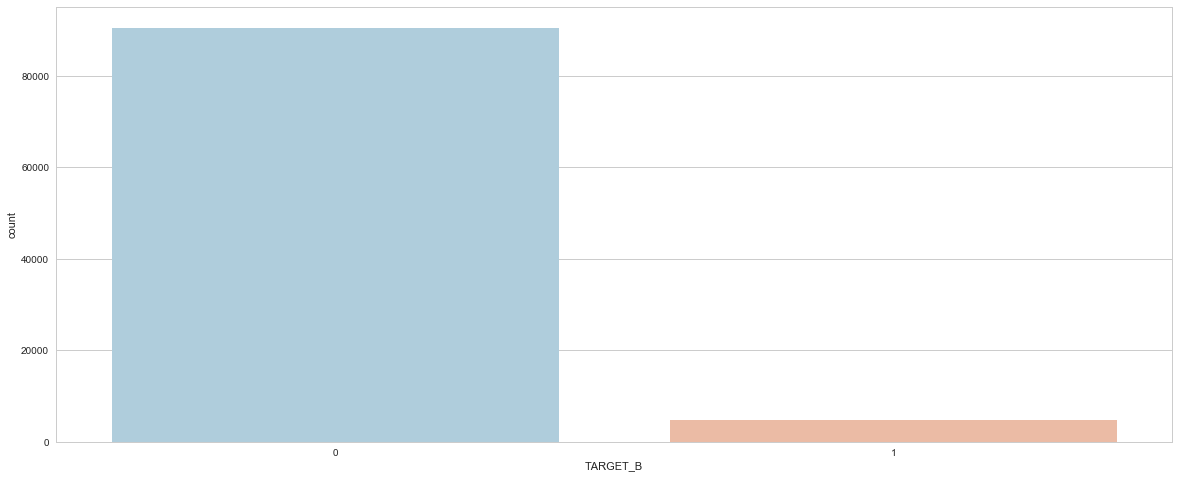

0    90569
1     4843
Name: TARGET_B, dtype: int64

In [44]:
### dependent variable distribution
sns.set_style('whitegrid')
sns.countplot(x='TARGET_B',data=data,palette='RdBu_r')
plt.show()

data['TARGET_B'].value_counts()
#data.groupby('TARGET_B').count()

Current size: [20.0, 8.0]


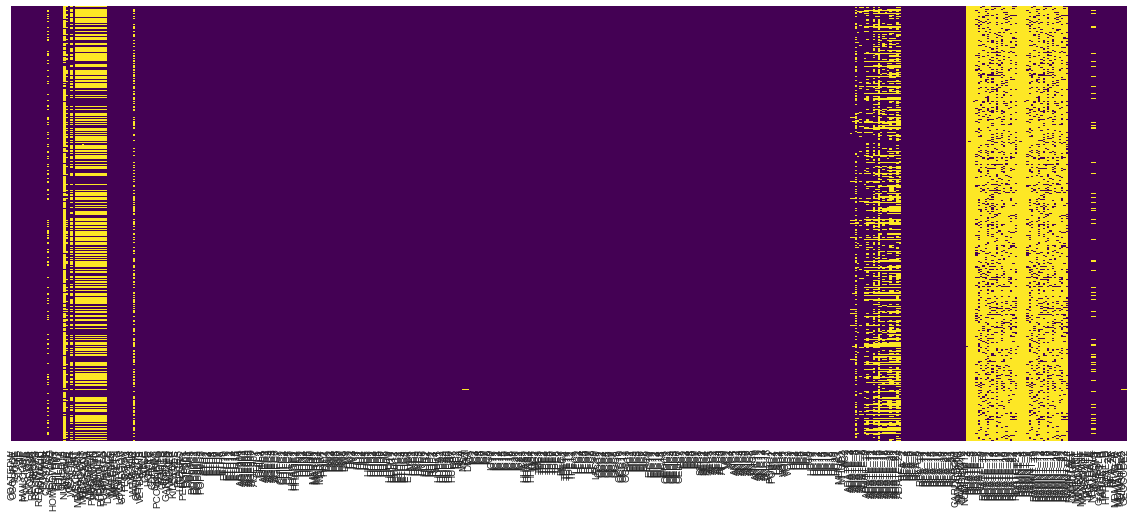

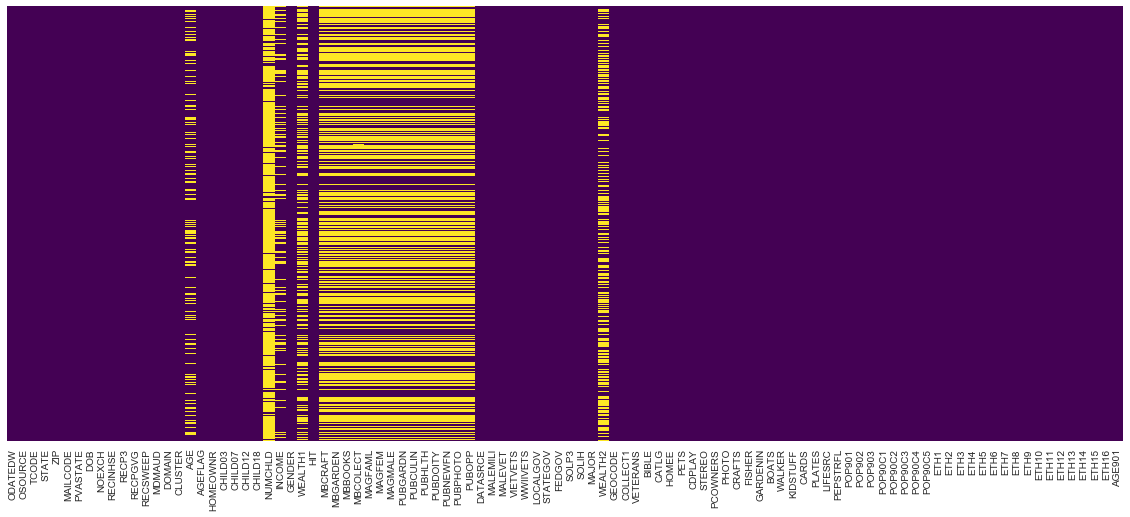

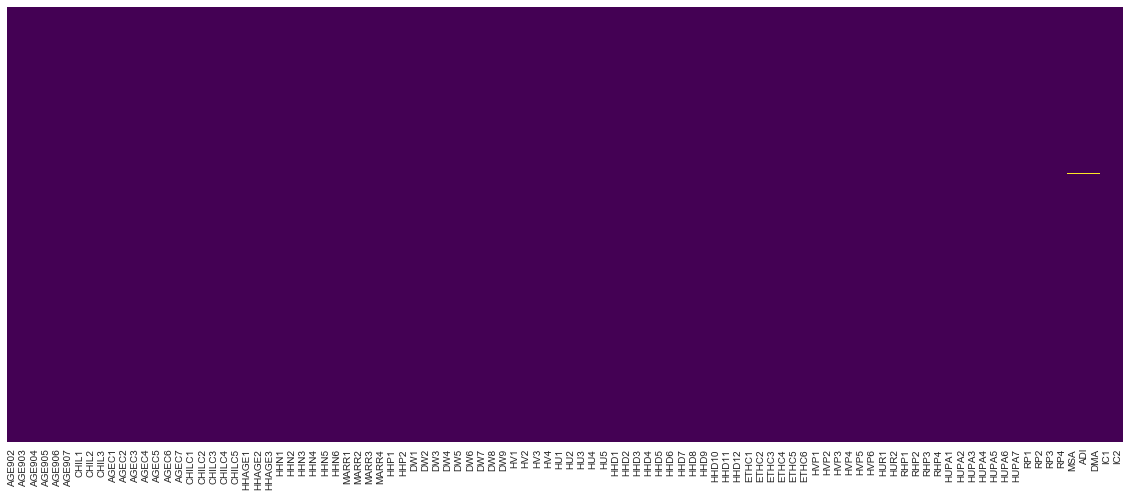

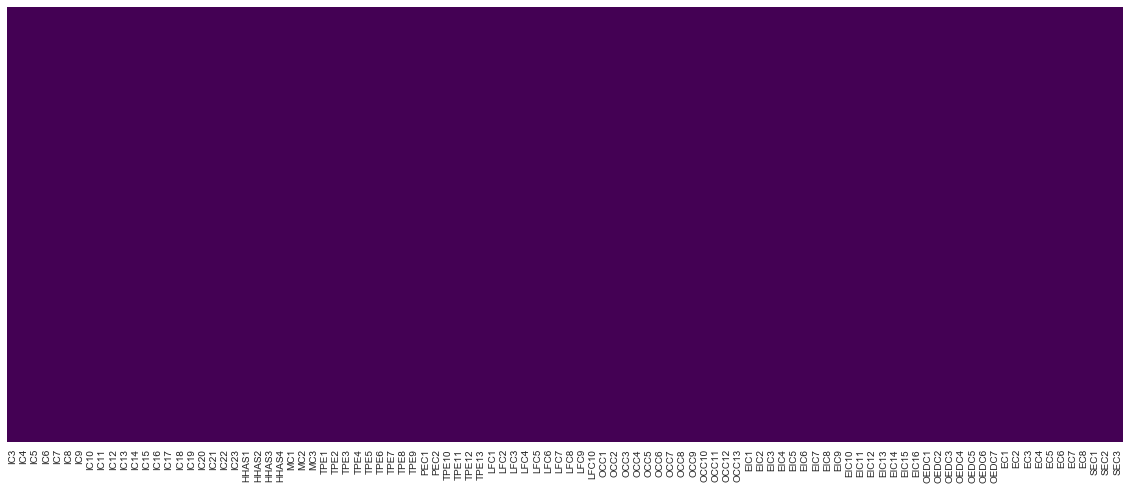

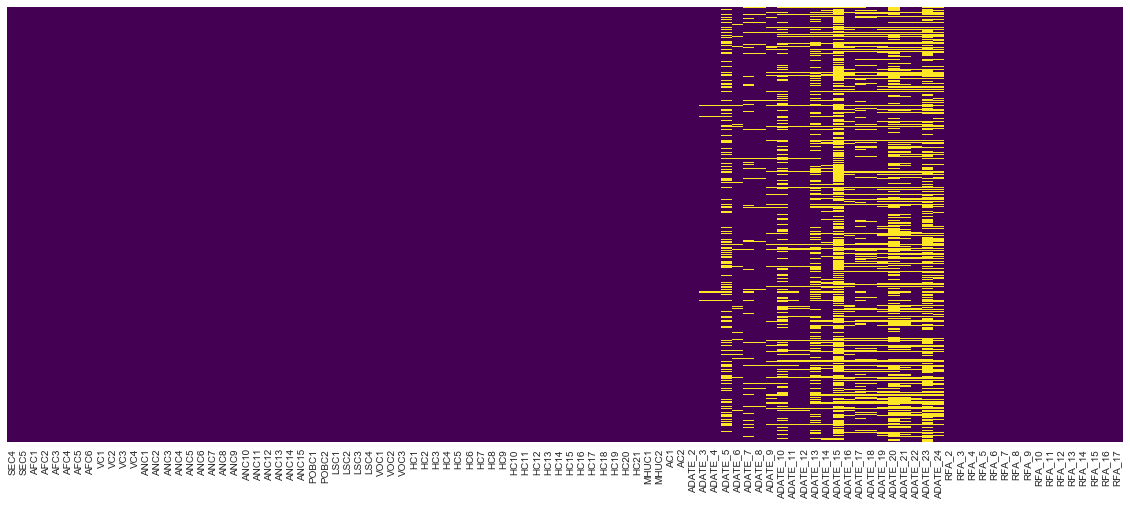

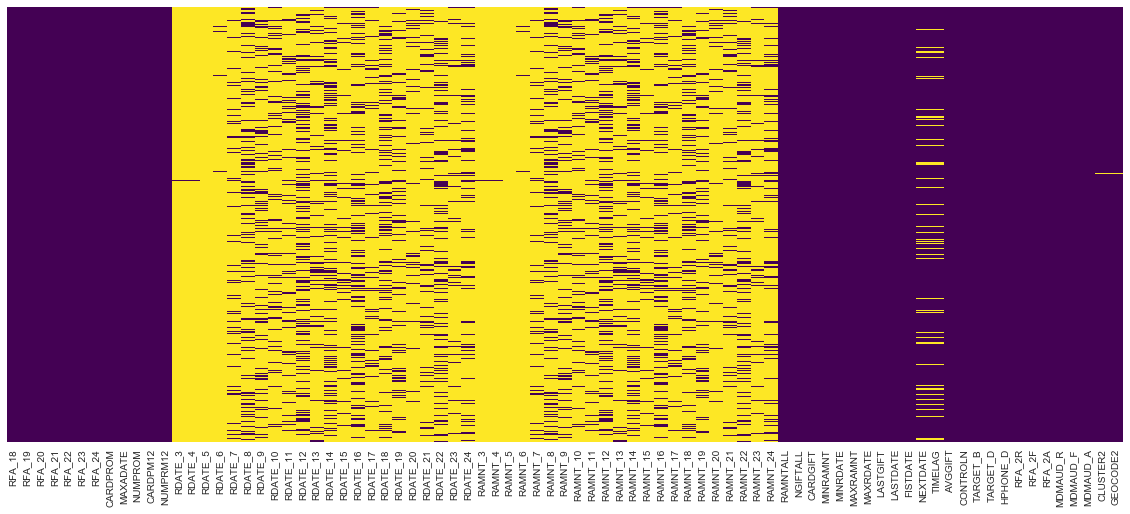

,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,...,TARGET_D,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
count,95412.000000,95412,95412.000000,95412,95412,95412,95412,95412.000000,95412,95412,...,95412.000000,95412.000000,95412,95412.000000,95412,95412,95412,95412,95280.000000,95280
unique,NaN,896,NaN,57,19938,2,3,NaN,6,2,...,NaN,NaN,1,NaN,4,5,4,5,NaN,5
top,NaN,MBC,NaN,CA,85351,,,NaN,0,,...,NaN,NaN,L,NaN,F,X,X,X,NaN,A
freq,NaN,4539,NaN,17343,61,94013,93954,NaN,61203,88709,...,NaN,NaN,95412,NaN,46964,95118,95118,95118,NaN,34484
mean,9141.363256,NaN,54.223117,NaN,NaN,NaN,NaN,2723.602933,NaN,NaN,...,0.793073,0.500618,NaN,1.910053,NaN,NaN,NaN,NaN,31.533711,NaN
std,343.454752,NaN,953.844476,NaN,NaN,NaN,NaN,2132.241295,NaN,NaN,...,4.429725,0.500002,NaN,1.072749,NaN,NaN,NaN,NaN,18.764614,NaN
min,8306.000000,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,0.000000,0.000000,NaN,1.000000,NaN,NaN,NaN,NaN,1.000000,NaN
25%,8801.000000,NaN,0.000000,NaN,NaN,NaN,NaN,201.000000,NaN,NaN,...,0.000000,0.000000,NaN,1.000000,NaN,NaN,NaN,NaN,15.000000,NaN
50%,9201.000000,NaN,1.000000,NaN,NaN,NaN,NaN,2610.000000,NaN,NaN,...,0.000000,1.000000,NaN,2.000000,NaN,NaN,NaN,NaN,32.000000,NaN
75%,9501.000000,NaN,2.000000,NaN,NaN,NaN,NaN,4601.000000,NaN,NaN,...,0.000000,1.000000,NaN,3.000000,NaN,NaN,NaN,NaN,49.000000,NaN


In [29]:
### skip the resampling step


### check missing values
"""
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()
"""

### Get current size
fig_size = plt.rcParams["figure.figsize"]
print('Current size:', fig_size)
 
### Set figure width and height
fig_width = 20 # width
fig_height = 8 # height
plt.rcParams["figure.figsize"] = [fig_width, fig_height]

### check missing values
sns.heatmap(data.isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data[data.columns[0:100]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data[data.columns[100:200]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data[data.columns[200:300]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data[data.columns[300:400]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data[data.columns[400:482]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

data.describe(include='all')

Before recoding, table shape: (95412, 481)
After imputation, table shape: (95412, 380)


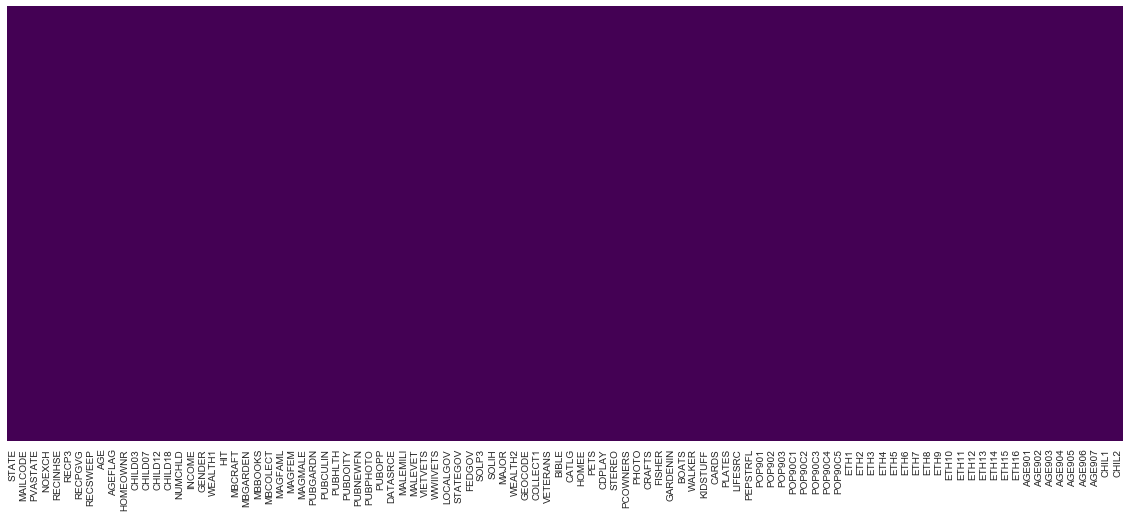

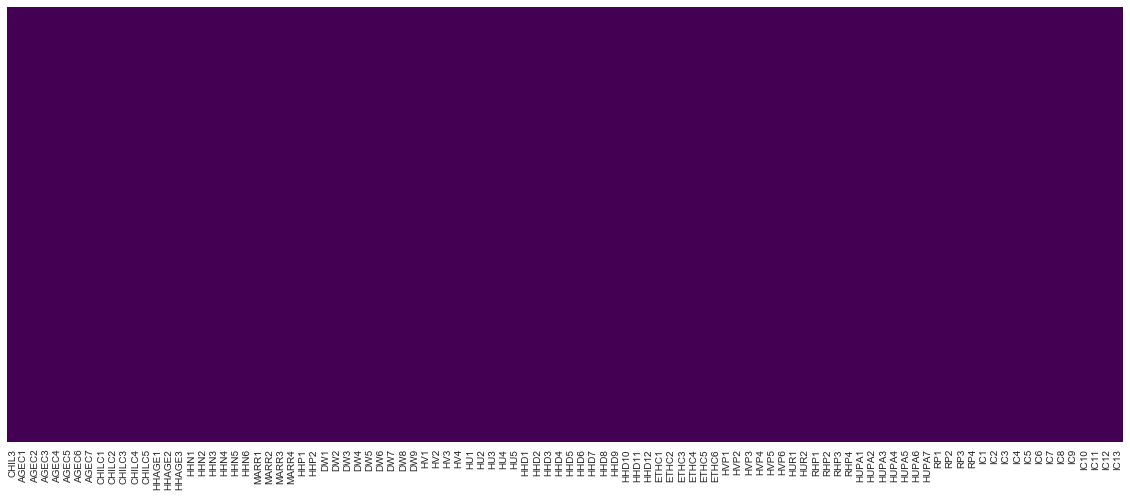

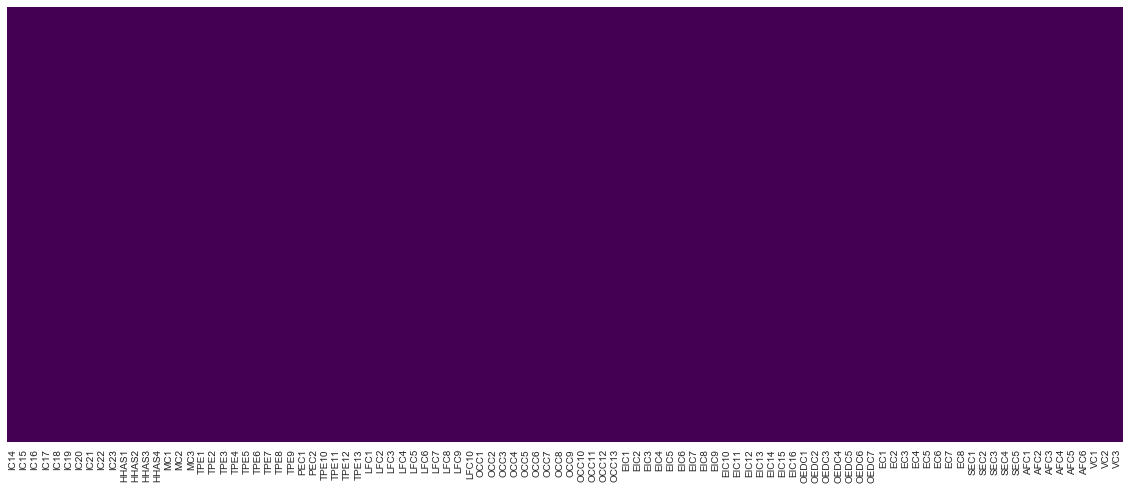

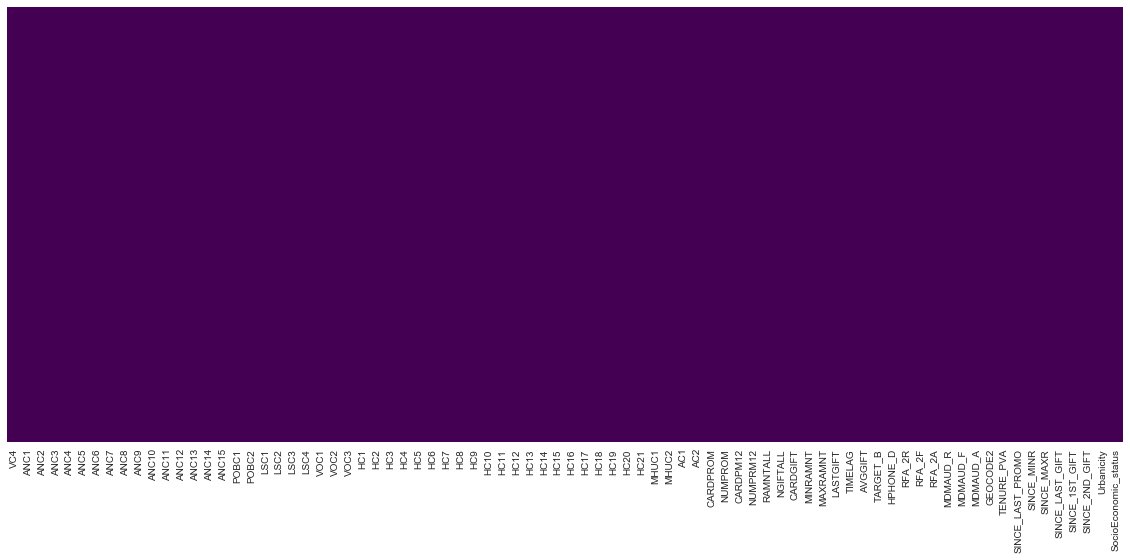

Afer recoding, table shape: (95412, 473)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Columns: 473 entries, MAILCODE to GEOCODE2_D
dtypes: float64(26), int64(343), uint8(104)
memory usage: 278.1 MB


,MAILCODE,PVASTATE,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,AGE,AGEFLAG,HOMEOWNR,...,GEOCODE_04,GEOCODE_05,GEOCODE_12,GEOCODE_14,RFA_2R_L,GEOCODE2_,GEOCODE2_A,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D
0,0,0,0,0,0,0,0,60.0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,46.0,1,1,...,0,0,0,0,1,0,1,0,0,0
2,0,0,0,0,0,0,0,62.0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,70.0,1,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,0,1,1,0,0,78.0,1,1,...,0,0,0,0,1,0,1,0,0,0


In [71]:
### recording

### recode the train set

input_data = data.copy()

var_drop_list = ['ODATEDW', 'TCODE','OSOURCE','ZIP','DOB','CLUSTER','MDMAUD','TARGET_D','CONTROLN',
                 'ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5', 'ADATE_6', 'ADATE_7', 'ADATE_8', 'ADATE_9',
                 'ADATE_10', 'ADATE_11', 'ADATE_12', 'ADATE_13', 'ADATE_14', 'ADATE_15', 'ADATE_16', 'ADATE_17',
                 'ADATE_18', 'ADATE_19', 'ADATE_20', 'ADATE_21', 'ADATE_22', 'ADATE_23', 'ADATE_24',
                 'RFA_2','RFA_3','RFA_4','RFA_5','RFA_6','RFA_7','RFA_8','RFA_9','RFA_10','RFA_11','RFA_12',
                 'RFA_13','RFA_14','RFA_15','RFA_16','RFA_17','RFA_18','RFA_19','RFA_20','RFA_21','RFA_22',
                 'RFA_23','RFA_24','MAXADATE','RDATE_3','RDATE_4','RDATE_5','RDATE_6','RDATE_7','RDATE_8',
                 'RDATE_9','RDATE_10','RDATE_11','RDATE_12','RDATE_13','RDATE_14','RDATE_15','RDATE_16',
                 'RDATE_17','RDATE_18','RDATE_19','RDATE_20','RDATE_21','RDATE_22','RDATE_23','RDATE_24',
                 'RAMNT_3','RAMNT_4','RAMNT_5','RAMNT_6','RAMNT_7','RAMNT_8','RAMNT_9','RAMNT_10','RAMNT_11',
                 'RAMNT_12','RAMNT_13','RAMNT_14','RAMNT_15','RAMNT_16','RAMNT_17','RAMNT_18','RAMNT_19','RAMNT_20',
                 'RAMNT_21','RAMNT_22','RAMNT_23','RAMNT_24','MINRDATE','MAXRDATE','LASTDATE','NEXTDATE','FISTDATE',
                 'CLUSTER2','DOMAIN','MSA','ADI','DMA'
                ]

# drop some variables

data_output = input_data.drop(labels = var_drop_list, axis=1)

# convert some flags

def rec_flags(value):
    if value in ['X','B','Y','E','H']:
        return 1
    else:
        return 0


var_flag_list = ['MAILCODE', 'PVASTATE', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP',
                 'AGEFLAG','HOMEOWNR','MAJOR','COLLECT1','VETERANS','BIBLE','CATLG','HOMEE','PETS',
                 'CDPLAY','STEREO','PCOWNERS','PHOTO','CRAFTS','FISHER','GARDENIN','BOATS','WALKER',
                 'KIDSTUFF','CARDS','PLATES','PEPSTRFL'
                ]

for var_raw in var_flag_list:
    data_output[var_raw] = input_data[var_raw].apply(rec_flags)


# fill some missings

input_data['AGE'] = input_data['AGE'].replace(0, None)
input_data['DOMAIN'] = input_data['DOMAIN'].replace(' ', None)
input_data['SOLP3'] = input_data['SOLP3'].replace(' ', None)   
input_data['SOLP3'] = input_data['SOLP3'].replace(' ', '15')
input_data['SOLIH'] = input_data['SOLP3'].replace(' ', '15')
input_data['LIFESRC'] = input_data['LIFESRC'].replace(' ', '0')
input_data['DATASRCE'] = input_data['DATASRCE'].replace(' ', '0')

for var in ['ODATEDW','MAXADATE','MINRDATE','MAXRDATE','LASTDATE','FISTDATE','NEXTDATE']:
    input_data[var] = input_data[var].replace(0, None)

# covert date to month_diff

def month_cal(YYMM):
    return int(str(YYMM)[0:2])*12 + int(str(YYMM)[2:4])

def month_diff(input_month, month_to_compare = 9807):
    if input_month is None or np.isnan(input_month):
        return None
    else:
        return month_cal(month_to_compare) - month_cal(input_month)


data_output['TENURE_PVA'] = input_data['ODATEDW'].apply(month_diff)
data_output['SINCE_LAST_PROMO'] = input_data['MAXADATE'].apply(month_diff)
data_output['SINCE_MINR'] = input_data['MINRDATE'].apply(month_diff)
data_output['SINCE_MAXR'] = input_data['MAXRDATE'].apply(month_diff)
data_output['SINCE_LAST_GIFT'] = input_data['LASTDATE'].apply(month_diff)
data_output['SINCE_1ST_GIFT'] = input_data['FISTDATE'].apply(month_diff)
data_output['SINCE_2ND_GIFT'] = input_data['NEXTDATE'].apply(month_diff)

# define some ordered variables

amount_dict = {'L':0, 'C':1, 'M':2, 'T':'3', 'X':0}
frequency_dict = {'1':1,'2':2,'3':3,'4':4,'5':5,'X':0}
amount2_dict = {'A':0, 'B':1, 'C':2, 'D':'3','E':'4','F':'5','G':'6','X':0}

data_output['Urbanicity'] = input_data['DOMAIN'].apply(lambda x: x[0])
data_output['SocioEconomic_status'] = input_data['DOMAIN'].apply(lambda x: int(x[1]))

data_output['SOLP3'] = input_data['SOLP3'].apply(int)
data_output['SOLIH'] = input_data['SOLIH'].apply(int)
data_output['LIFESRC'] = input_data['LIFESRC'].apply(int)

data_output['RFA_2F'] = input_data['RFA_2F'].apply(lambda x: frequency_dict[str(x)])
data_output['RFA_2A'] = input_data['RFA_2A'].apply(lambda x: amount2_dict[x]).astype(int)

data_output['MDMAUD_F'] = input_data['MDMAUD_F'].apply(lambda x: frequency_dict[x])
data_output['MDMAUD_A'] = input_data['MDMAUD_A'].apply(lambda x: amount_dict[x]).astype(int)

data_output['DATASRCE'] = input_data['DATASRCE'].astype(int)

# adjust nominal variable dtype
var_cate_list = ['MDMAUD_R','Urbanicity','CHILD03','CHILD07','CHILD12', 'CHILD18', 'GENDER', 'STATE',
                 'GEOCODE','RFA_2R','GEOCODE2'
                ]

data_output[var_cate_list] = data_output[var_cate_list].astype(object)

# Imputation of missing values. freq for nominal, median for numberic
missing_recode = Missing_Imputer()
missing_recode.fit(data_output)
data_output = missing_recode.transform(data_output)

# new heatmaps after Imputation
print('Before recoding, table shape:',data.shape)
print('After imputation, table shape:',data_output.shape)

### Set figure width and height
fig_width = 20 # width
fig_height = 8 # height
plt.rcParams["figure.figsize"] = [fig_width, fig_height]

sns.heatmap(data_output[data_output.columns[0:100]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data_output[data_output.columns[100:200]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data_output[data_output.columns[200:300]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data_output[data_output.columns[300:383]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

# Encoding categorical features
'''
Right now, OneHotEncoder only support numeric variables.
Example:
OneHotEncoder(sparse = False).fit_transform( testdata[['age']] )

For string, there are two commmon ways.

1) Apply LabelEncoder() to convert strings into numbers, then apply OneHotEncoder().
Example:
testdata = pd.DataFrame({'pet': ['cat', 'dog', 'dog', 'fish', None, None],                         
'age': [4 , 6, 3, 3, None, None],                         
'salary':[4, 5, 1, 1, None, None]})
a = LabelEncoder().fit_transform(testdata['pet'])
OneHotEncoder( sparse=False ).fit_transform(a.reshape(-1,1))

2) Apply LabelBinarizer() directly. Note: LabelBinarizer() only accepts 1-D array.
Example:
LabelBinarizer().fit_transform(testdata['pet'])

3) Apply pd.get_dummies() in pandas
Example:
pd.get_dummies(testdata['pet'])

Before when OneHotEncoder() supports string, I use pd.get_dummies().
'''
# create dummy variables

data_output = pd.concat([data_output.drop(labels = var_cate_list, axis=1)
                         ,pd.get_dummies(data_output[var_cate_list])], axis=1)

# check the dimensions

print('Afer recoding, table shape:',data_output.shape)

train_set = data_output.copy()
train_set.info()
train_set.head()

Before recoding, table shape: (95412, 481)
After imputation, table shape: (95412, 380)


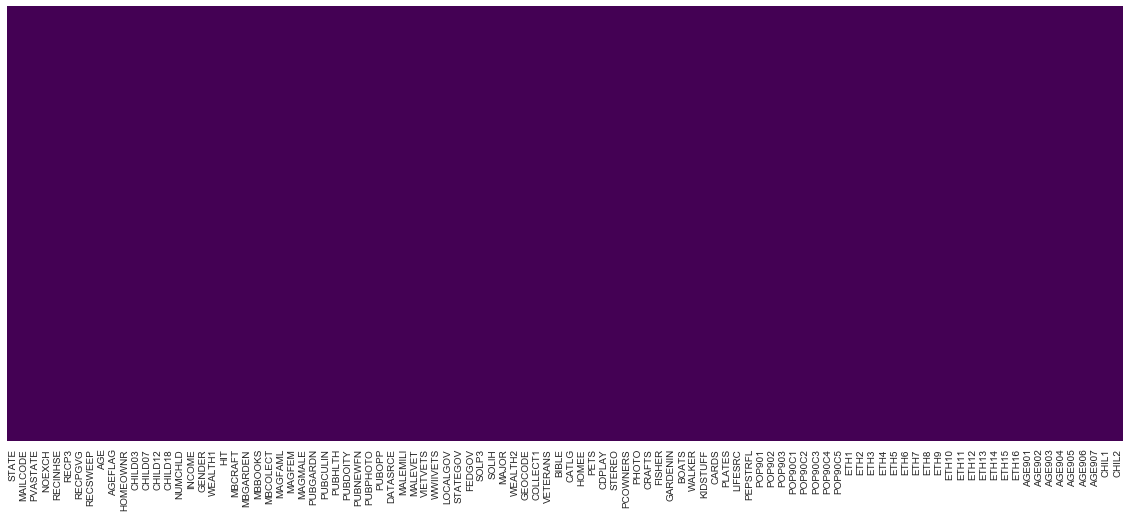

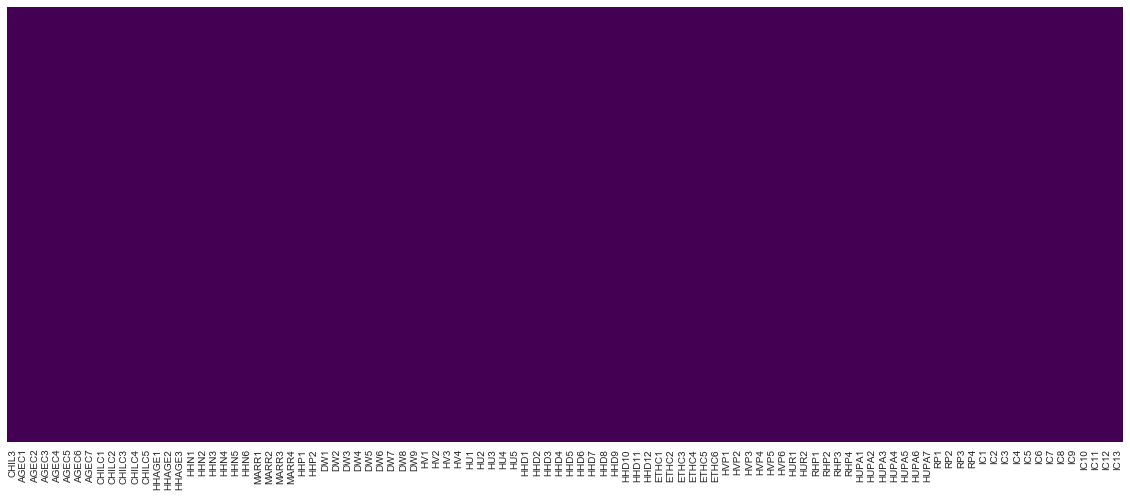

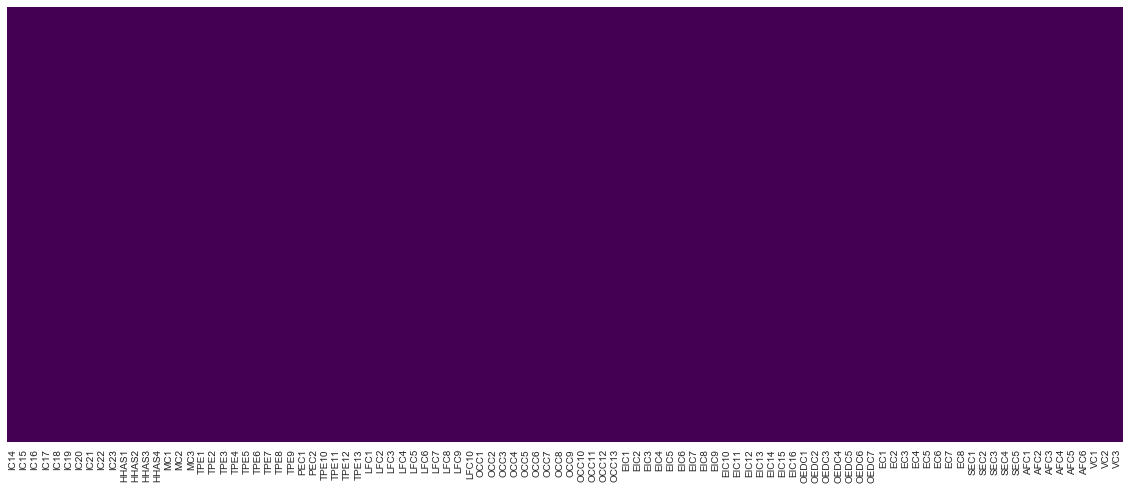

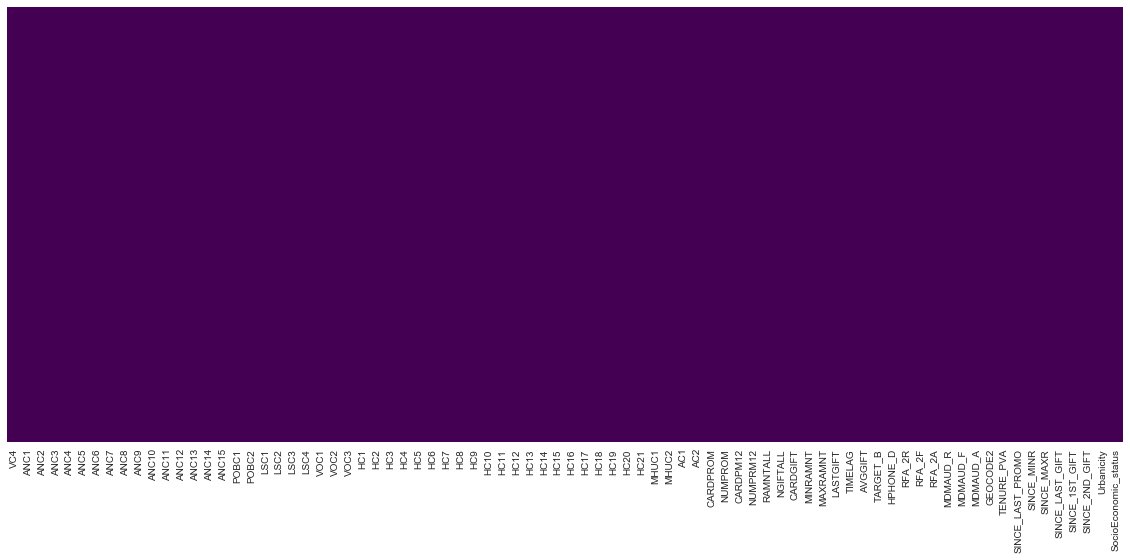

Afer recoding, table shape: (95412, 473)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95412 entries, 0 to 95411
Columns: 473 entries, MAILCODE to GEOCODE2_D
dtypes: float64(26), int64(343), uint8(104)
memory usage: 278.1 MB


,MAILCODE,PVASTATE,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,AGE,AGEFLAG,HOMEOWNR,...,GEOCODE_04,GEOCODE_05,GEOCODE_12,GEOCODE_14,RFA_2R_L,GEOCODE2_,GEOCODE2_A,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D
0,0,0,0,0,0,0,0,60.0,0,0,...,0,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,46.0,1,1,...,0,0,0,0,1,0,1,0,0,0
2,0,0,0,0,0,0,0,62.0,0,0,...,0,0,0,0,1,0,0,0,1,0
3,0,0,0,0,0,0,0,70.0,1,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0,0,1,1,0,0,78.0,1,1,...,0,0,0,0,1,0,1,0,0,0


In [72]:
# recode test set

input_data = data_v.copy()

var_drop_list = ['ODATEDW', 'TCODE','OSOURCE','ZIP','DOB','CLUSTER','MDMAUD','TARGET_D','CONTROLN',
                 'ADATE_2', 'ADATE_3', 'ADATE_4', 'ADATE_5', 'ADATE_6', 'ADATE_7', 'ADATE_8', 'ADATE_9',
                 'ADATE_10', 'ADATE_11', 'ADATE_12', 'ADATE_13', 'ADATE_14', 'ADATE_15', 'ADATE_16', 'ADATE_17',
                 'ADATE_18', 'ADATE_19', 'ADATE_20', 'ADATE_21', 'ADATE_22', 'ADATE_23', 'ADATE_24',
                 'RFA_2','RFA_3','RFA_4','RFA_5','RFA_6','RFA_7','RFA_8','RFA_9','RFA_10','RFA_11','RFA_12',
                 'RFA_13','RFA_14','RFA_15','RFA_16','RFA_17','RFA_18','RFA_19','RFA_20','RFA_21','RFA_22',
                 'RFA_23','RFA_24','MAXADATE','RDATE_3','RDATE_4','RDATE_5','RDATE_6','RDATE_7','RDATE_8',
                 'RDATE_9','RDATE_10','RDATE_11','RDATE_12','RDATE_13','RDATE_14','RDATE_15','RDATE_16',
                 'RDATE_17','RDATE_18','RDATE_19','RDATE_20','RDATE_21','RDATE_22','RDATE_23','RDATE_24',
                 'RAMNT_3','RAMNT_4','RAMNT_5','RAMNT_6','RAMNT_7','RAMNT_8','RAMNT_9','RAMNT_10','RAMNT_11',
                 'RAMNT_12','RAMNT_13','RAMNT_14','RAMNT_15','RAMNT_16','RAMNT_17','RAMNT_18','RAMNT_19','RAMNT_20',
                 'RAMNT_21','RAMNT_22','RAMNT_23','RAMNT_24','MINRDATE','MAXRDATE','LASTDATE','NEXTDATE','FISTDATE',
                 'CLUSTER2','DOMAIN','MSA','ADI','DMA'
                ]

# drop some variables

data_output = input_data.drop(labels = var_drop_list, axis=1)

# convert some flags

def rec_flags(value):
    if value in ['X','B','Y','E','H']:
        return 1
    else:
        return 0


var_flag_list = ['MAILCODE', 'PVASTATE', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP',
                 'AGEFLAG','HOMEOWNR','MAJOR','COLLECT1','VETERANS','BIBLE','CATLG','HOMEE','PETS',
                 'CDPLAY','STEREO','PCOWNERS','PHOTO','CRAFTS','FISHER','GARDENIN','BOATS','WALKER',
                 'KIDSTUFF','CARDS','PLATES','PEPSTRFL'
                ]

for var_raw in var_flag_list:
    data_output[var_raw] = input_data[var_raw].apply(rec_flags)


# fill some missings

input_data['AGE'] = input_data['AGE'].replace(0, None)
input_data['DOMAIN'] = input_data['DOMAIN'].replace(' ', None)
input_data['SOLP3'] = input_data['SOLP3'].replace(' ', None)   
input_data['SOLP3'] = input_data['SOLP3'].replace(' ', '15')
input_data['SOLIH'] = input_data['SOLP3'].replace(' ', '15')
input_data['LIFESRC'] = input_data['LIFESRC'].replace(' ', '0')
input_data['DATASRCE'] = input_data['DATASRCE'].replace(' ', '0')


for var in ['ODATEDW','MAXADATE','MINRDATE','MAXRDATE','LASTDATE','FISTDATE','NEXTDATE']:
    input_data[var] = input_data[var].replace(0, None)

# covert date to month_diff

def month_cal(YYMM):
    return int(str(YYMM)[0:2])*12 + int(str(YYMM)[2:4])

def month_diff(input_month, month_to_compare = 9807):
    if input_month is None or np.isnan(input_month):
        return None
    else:
        return month_cal(month_to_compare) - month_cal(input_month)


data_output['TENURE_PVA'] = input_data['ODATEDW'].apply(month_diff)
data_output['SINCE_LAST_PROMO'] = input_data['MAXADATE'].apply(month_diff)
data_output['SINCE_MINR'] = input_data['MINRDATE'].apply(month_diff)
data_output['SINCE_MAXR'] = input_data['MAXRDATE'].apply(month_diff)
data_output['SINCE_LAST_GIFT'] = input_data['LASTDATE'].apply(month_diff)
data_output['SINCE_1ST_GIFT'] = input_data['FISTDATE'].apply(month_diff)
data_output['SINCE_2ND_GIFT'] = input_data['NEXTDATE'].apply(month_diff)

# define some ordered variables

amount_dict = {'L':0, 'C':1, 'M':2, 'T':'3', 'X':0}
frequency_dict = {'1':1,'2':2,'3':3,'4':4,'5':5,'X':0}
amount2_dict = {'A':0, 'B':1, 'C':2, 'D':'3','E':'4','F':'5','G':'6','X':0}

data_output['Urbanicity'] = input_data['DOMAIN'].apply(lambda x: x[0])
data_output['SocioEconomic_status'] = input_data['DOMAIN'].apply(lambda x: int(x[1]))

data_output['SOLP3'] = input_data['SOLP3'].apply(int)
data_output['SOLIH'] = input_data['SOLIH'].apply(int)
data_output['LIFESRC'] = input_data['LIFESRC'].apply(int)

data_output['RFA_2F'] = input_data['RFA_2F'].apply(lambda x: frequency_dict[str(x)])
data_output['RFA_2A'] = input_data['RFA_2A'].apply(lambda x: amount2_dict[x]).astype(int)

data_output['MDMAUD_F'] = input_data['MDMAUD_F'].apply(lambda x: frequency_dict[x])
data_output['MDMAUD_A'] = input_data['MDMAUD_A'].apply(lambda x: amount_dict[x]).astype(int)

data_output['DATASRCE'] = input_data['DATASRCE'].astype(int)

# adjust nominal variable dtype
var_cate_list = ['MDMAUD_R','Urbanicity','CHILD03','CHILD07','CHILD12', 'CHILD18', 'GENDER', 'STATE',
                 'GEOCODE','RFA_2R','GEOCODE2'
                ]

data_output[var_cate_list] = data_output[var_cate_list].astype(object)

# Imputation of missing values. freq for nominal, median for numberic
#missing_recode = Missing_Imputer()
#missing_recode.fit(data_output)
data_output = missing_recode.transform(data_output)

# new heatmaps after Imputation
print('Before recoding, table shape:',data.shape)
print('After imputation, table shape:',data_output.shape)

### Set figure width and height
fig_width = 20 # width
fig_height = 8 # height
plt.rcParams["figure.figsize"] = [fig_width, fig_height]

sns.heatmap(data_output[data_output.columns[0:100]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data_output[data_output.columns[100:200]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data_output[data_output.columns[200:300]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

sns.heatmap(data_output[data_output.columns[300:383]].isnull(),yticklabels=False,cbar=False,cmap='viridis')
plt.show()

# Encoding categorical features
'''
Right now, OneHotEncoder only support numeric variables.
Example:
OneHotEncoder(sparse = False).fit_transform( testdata[['age']] )

For string, there are two commmon ways.

1) Apply LabelEncoder() to convert strings into numbers, then apply OneHotEncoder().
Example:
testdata = pd.DataFrame({'pet': ['cat', 'dog', 'dog', 'fish', None, None],                         
'age': [4 , 6, 3, 3, None, None],                         
'salary':[4, 5, 1, 1, None, None]})
a = LabelEncoder().fit_transform(testdata['pet'])
OneHotEncoder( sparse=False ).fit_transform(a.reshape(-1,1))

2) Apply LabelBinarizer() directly. Note: LabelBinarizer() only accepts 1-D array.
Example:
LabelBinarizer().fit_transform(testdata['pet'])

3) Apply pd.get_dummies() in pandas
Example:
pd.get_dummies(testdata['pet'])

Before when OneHotEncoder() supports string, I use pd.get_dummies().
'''
# create dummy variables

data_output = pd.concat([data_output.drop(labels = var_cate_list, axis=1)
                         ,pd.get_dummies(data_output[var_cate_list])], axis=1)

# check the dimensions

print('Afer recoding, table shape:',data_output.shape)

test_set = data_output.copy()
test_set.info()
test_set.head()

In [8]:
# setup independent var and dependent var

data_ready = train_set

X_col0 = list(data_ready.columns)
#print(X_col0)

print('\nVariables included:')
X_col = []
for val in X_col0:
    if val not in ['TARGET_B']:
        X_col.append(val) ### remove some variables to tune the model, start from the dependent variable

y_col = 'TARGET_B' ### change every time

print('\n')
print(X_col)
print(y_col)
print('\n')

X = data_ready[X_col] ### set of independent variables
y = np.array(data_ready[y_col],dtype = 'int32')

# check if all variables are numeric

check_non_num(X_col, X)
            
### split train and test set
'''
When test set is not provided, use:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=1, random_state=6449)
'''
X_train = X
X_test = test_set[X_col]
y_train = y
y_test = np.array(test_set[y_col],dtype = 'int32')

# variable standardization for variable selection

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(X_train)
X_standardized_train = pd.DataFrame(min_max_scaler.transform(X_train), columns=X_col)
X_standardized_test = pd.DataFrame(min_max_scaler.transform(X_test), columns=X_col)

print('X_train size: %s' % str(X_train.shape))
print('X_test size: %s' % str(X_test.shape))
print('X_standardized_train size: %s' % str(X_standardized_train.shape))

print('y_train size: %s' % str(y_train.shape))
print('y_test size: %s' % str(y_test.shape))

X_standardized_train.describe(include='all')


Variables included:


['MAILCODE', 'PVASTATE', 'NOEXCH', 'RECINHSE', 'RECP3', 'RECPGVG', 'RECSWEEP', 'AGE', 'AGEFLAG', 'HOMEOWNR', 'NUMCHLD', 'INCOME', 'WEALTH1', 'HIT', 'MBCRAFT', 'MBGARDEN', 'MBBOOKS', 'MBCOLECT', 'MAGFAML', 'MAGFEM', 'MAGMALE', 'PUBGARDN', 'PUBCULIN', 'PUBHLTH', 'PUBDOITY', 'PUBNEWFN', 'PUBPHOTO', 'PUBOPP', 'DATASRCE', 'MALEMILI', 'MALEVET', 'VIETVETS', 'WWIIVETS', 'LOCALGOV', 'STATEGOV', 'FEDGOV', 'SOLP3', 'SOLIH', 'MAJOR', 'WEALTH2', 'COLLECT1', 'VETERANS', 'BIBLE', 'CATLG', 'HOMEE', 'PETS', 'CDPLAY', 'STEREO', 'PCOWNERS', 'PHOTO', 'CRAFTS', 'FISHER', 'GARDENIN', 'BOATS', 'WALKER', 'KIDSTUFF', 'CARDS', 'PLATES', 'LIFESRC', 'PEPSTRFL', 'POP901', 'POP902', 'POP903', 'POP90C1', 'POP90C2', 'POP90C3', 'POP90C4', 'POP90C5', 'ETH1', 'ETH2', 'ETH3', 'ETH4', 'ETH5', 'ETH6', 'ETH7', 'ETH8', 'ETH9', 'ETH10', 'ETH11', 'ETH12', 'ETH13', 'ETH14', 'ETH15', 'ETH16', 'AGE901', 'AGE902', 'AGE903', 'AGE904', 'AGE905', 'AGE906', 'AGE907', 'CHIL1', 'CHIL2', 'CHIL3', 'AGEC1', 'AGEC2',

,MAILCODE,PVASTATE,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,AGE,AGEFLAG,HOMEOWNR,...,GEOCODE_04,GEOCODE_05,GEOCODE_12,GEOCODE_14,RFA_2R_L,GEOCODE2_,GEOCODE2_A,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D
count,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000,...,95412.000000,95412.000000,95412.000000,95412.000000,95412.0,95412.000000,95412.000000,95412.000000,95412.000000,95412.000000
mean,0.014663,0.000052,0.000367,0.070253,0.021140,0.001195,0.016948,0.625855,0.601015,0.548715,...,0.017000,0.020102,0.041022,0.021140,0.0,0.001960,0.362806,0.298757,0.162705,0.173773
std,0.120199,0.007239,0.019149,0.255575,0.143851,0.034546,0.129076,0.148985,0.489692,0.497624,...,0.129272,0.140351,0.198342,0.143851,0.0,0.044228,0.480812,0.457715,0.369098,0.378916
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.525773,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.628866,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.721649,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000


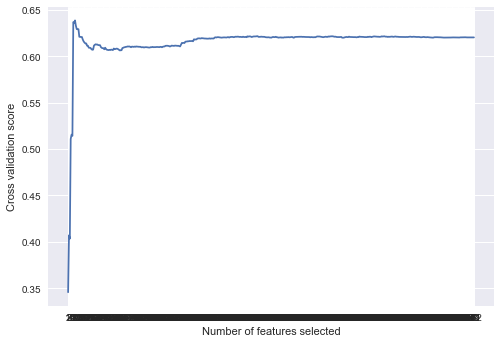


Optimal number of features : 9



In [10]:
### variable reduction

# specify the model
estimator = linear_model.LogisticRegression(class_weight='balanced')  # estimator for RFE, select the suitable model 

# select variables using RFECV
selector = RFECV(estimator, step=1, cv=3, n_jobs=-1, scoring=None)
selector = selector.fit(X_standardized_train, y_train)


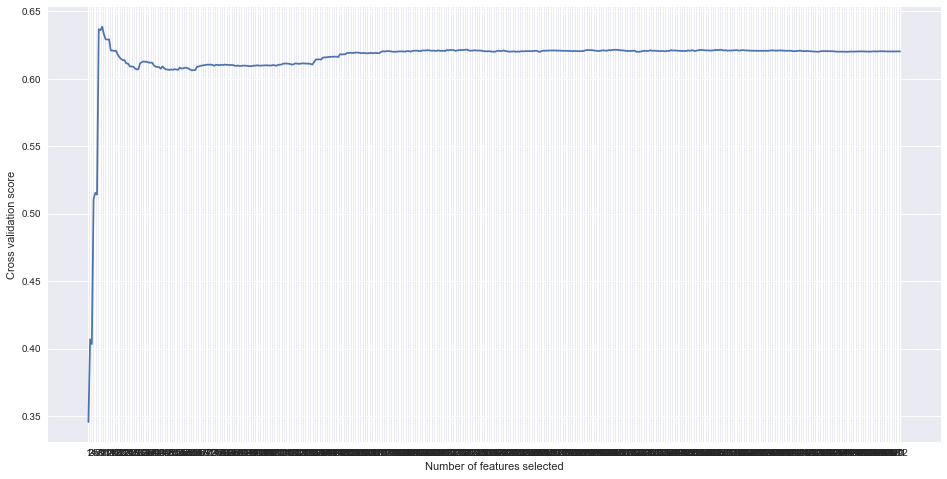


Optimal number of features : 9



In [74]:
# plot RFECV result

plt.clf()

# Set figure width and height
fig_width = 16 # width
fig_height = 8 # height
plt.rcParams["figure.figsize"] = [fig_width, fig_height]

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score")
plt.xticks(range(1, len(selector.grid_scores_) + 1))
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

print("\nOptimal number of features : %d\n" % selector.n_features_)

In [68]:
### show the selected variables
selection = list(zip(selector.ranking_, selector.support_, X_standardized_train.columns))
selection.sort()
for i in selection[:21]:
    print(i)

### clean dataset for modeling 
selected_val0 = X_standardized_train.columns[selector.support_]
print(selected_val0)

(1, True, 'CARDGIFT')
(1, True, 'CHILD03_B')
(1, True, 'ETH10')
(1, True, 'HHD7')
(1, True, 'HHD8')
(1, True, 'MINRAMNT')
(1, True, 'STATE_MA')
(1, True, 'STATE_OH')
(1, True, 'TIMELAG')
(2, False, 'GENDER_A')
(3, False, 'SINCE_2ND_GIFT')
(4, False, 'SINCE_1ST_GIFT')
(5, False, 'STATE_WV')
(6, False, 'STATE_ME')
(7, False, 'STATE_GU')
(8, False, 'STATE_AA')
(9, False, 'RHP4')
(10, False, 'DW4')
(11, False, 'DW1')
(12, False, 'HUPA3')
(13, False, 'HU4')
Index(['ETH10', 'HHD7', 'HHD8', 'CARDGIFT', 'MINRAMNT', 'TIMELAG', 'CHILD03_B',
       'STATE_MA', 'STATE_OH'],
      dtype='object')


In [14]:
### clean dataset for modeling 

#selected_val = selected_val0 # adjust if necessary
selected_val = ['ETH10', 'HHD7', 'HHD8', 'CARDGIFT', 'MINRAMNT', 'TIMELAG', 'CHILD03_B',
       'STATE_MA', 'STATE_OH']

X_train_new,X_test_new = X_train[selected_val],X_test[selected_val] # using the non-standardized data

print('\nX_train_new size: %s' % str(X_train_new.shape))
print('X_test_new size: %s' % str(X_test_new.shape))


X_train_new size: (95412, 9)
X_test_new size: (95412, 9)


In [16]:
# create model
estimator.fit(X_train_new,y_train)

# print the intercept and coefficients
coeff_df = pd.DataFrame(np.transpose(np.append(estimator.intercept_, estimator.coef_))
                        ,['Intercept',]+list(X_train_new.columns)
                        ,columns=['Coefficient'])

coeff_df

,Coefficient
Intercept,-0.022349
ETH10,0.041845
HHD7,-0.027497
HHD8,0.058369
CARDGIFT,0.043039
MINRAMNT,-0.011037
TIMELAG,-0.003814
CHILD03_B,-2.145085
STATE_MA,-1.765178
STATE_OH,-2.305375


Training Set Accuracy 0.589768582568
Training Set Area Under the ROC 0.583318923742


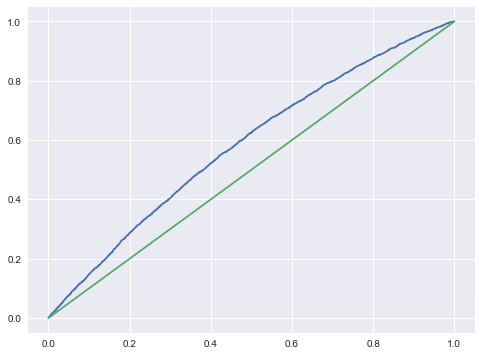

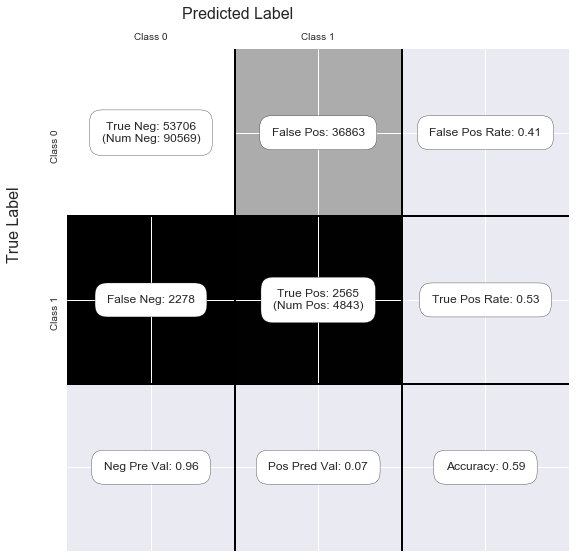

             precision    recall  f1-score   support

          0       0.96      0.59      0.73     90569
          1       0.07      0.53      0.12      4843

avg / total       0.91      0.59      0.70     95412



,decile,size,resp,resp %,cum. resp,cum. resp %
0,1,9542,698,14.41,698,14.41
1,2,9542,662,13.67,1360,28.08
2,3,9540,571,11.79,1931,39.87
3,4,9549,560,11.56,2491,51.44
4,5,9533,513,10.59,3004,62.03
5,6,9541,436,9.00,3440,71.03
6,7,9541,414,8.55,3854,79.58
7,8,9542,377,7.78,4231,87.36
8,9,9540,340,7.02,4571,94.38
9,10,9542,272,5.62,4843,100.00


In [18]:
# check the performance on the training set
predicted_t = estimator.predict(X_train_new)
probs_t = estimator.predict_proba(X_train_new)

print('Training Set Accuracy',metrics.accuracy_score(y_train, predicted_t))
print('Training Set Area Under the ROC',metrics.roc_auc_score(y_train, probs_t[:, 1]))

### Set figure width and height
fig_width = 8 # width
fig_height = 6 # height
plt.rcParams["figure.figsize"] = [fig_width, fig_height]

fpr, tpr, thresholds = metrics.roc_curve(y_train, probs_t[:, 1], pos_label=1)
plt.plot(fpr, tpr, label='Train')
plt.plot([0, 1], [0, 1], '-')
plt.show()

show_confusion_matrix(metrics.confusion_matrix(y_train, predicted_t), ['Class 0', 'Class 1'])

print(metrics.classification_report(y_train, predicted_t))

top_centiles_pref(y_train, probs_t[:, 1])

In [19]:
# VIF using training set

vif_cal(X_train_new)

,Variable,VIF
0,ETH10,1.00
1,HHD7,1.62
2,HHD8,1.62
3,CARDGIFT,1.17
4,MINRAMNT,1.16
5,TIMELAG,1.01
6,CHILD03_B,1.00
7,STATE_MA,1.00
8,STATE_OH,1.00


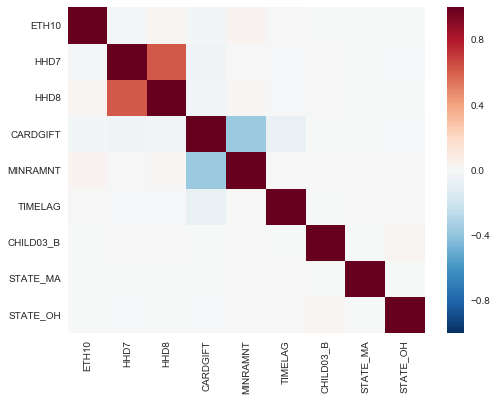

In [20]:
# plot the variable correlation on training set
sns.heatmap(X_train_new.corr())
plt.show()

In [21]:
# variable profiling on training set
fnl_train_data = pd.concat([X_train_new, pd.DataFrame(y_train, columns=[y_col])], axis=1)

# check the variable correlation on training set
fnl_train_data.corr()

,ETH10,HHD7,HHD8,CARDGIFT,MINRAMNT,TIMELAG,CHILD03_B,STATE_MA,STATE_OH,TARGET_B
ETH10,1.000000,-0.023350,0.021667,-0.029532,0.030627,0.001844,-0.001032,-0.002752,-0.004041,0.008822
HHD7,-0.023350,1.000000,0.618377,-0.041612,0.003043,-0.008093,0.000101,-0.001326,-0.009702,-0.020671
HHD8,0.021667,0.618377,1.000000,-0.038750,0.009359,-0.008259,0.007311,-0.005528,-0.007366,-0.004965
CARDGIFT,-0.029532,-0.041612,-0.038750,1.000000,-0.370640,-0.069155,-0.002526,-0.003642,-0.007840,0.054027
MINRAMNT,0.030627,0.003043,0.009359,-0.370640,1.000000,0.002801,0.000971,0.003513,0.004266,-0.031008
TIMELAG,0.001844,-0.008093,-0.008259,-0.069155,0.002801,1.000000,-0.003611,0.000841,0.000547,-0.007838
CHILD03_B,-0.001032,0.000101,0.007311,-0.002526,0.000971,-0.003611,1.000000,-0.000332,0.021459,-0.004736
STATE_MA,-0.002752,-0.001326,-0.005528,-0.003642,0.003513,0.000841,-0.000332,1.000000,-0.000378,-0.003744
STATE_OH,-0.004041,-0.009702,-0.007366,-0.007840,0.004266,0.000547,0.021459,-0.000378,1.000000,-0.005400
TARGET_B,0.008822,-0.020671,-0.004965,0.054027,-0.031008,-0.007838,-0.004736,-0.003744,-0.005400,1.000000


In [66]:
# check the partial correlation

pc = partial_corr(fnl_train_data[['HHD7','HHD8','TARGET_B']])
pd.DataFrame(pc, columns =['HHD7','HHD8','TARGET_B'], index=['HHD7','HHD8','TARGET_B'] )


,HHD7,HHD8,TARGET_B
HHD7,1.000000,0.654306,0.015929
HHD8,0.654306,1.000000,0.045082
TARGET_B,0.015929,0.045082,1.000000


In [25]:
#auto_countplot(fnl_train_data, y_col)
'''
ETH10          Percent Korean
HHD7           Percent Single Parent Households
HHD8           Percent Male Householder w/ Child
CARDGIFT       Number of lifetime gifts to card promotions to date 
MINRAMNT       Dollar amount of smallest gift to date
TIMELAG        Number of months between first and second gift
CHILD03_B      Presence of Children age 0-3, B = Both female and male
STATE_MA       State abbreviation: MA
STATE_OH       State abbreviation: OH

Intercept -0.022349
ETH10 0.041845
HHD7 -0.027497
HHD8 0.058369
CARDGIFT 0.043039
MINRAMNT -0.011037
TIMELAG -0.003814
CHILD03_B -2.145085
STATE_MA -1.765178
STATE_OH -2.305375
'''


#pprof.ProfileReport(X_train_new)

print(fnl_train_data.groupby(['STATE_MA','TARGET_B']).count().iloc[:,0])
print(fnl_train_data.groupby(['STATE_OH','TARGET_B']).count().iloc[:,0])
print(fnl_train_data.groupby(['CHILD03_B','TARGET_B']).count().iloc[:,0])

STATE_MA  TARGET_B
0         0           90544
          1            4843
1         0              25
Name: ETH10, dtype: int64
STATE_OH  TARGET_B
0         0           90517
          1            4843
1         0              52
Name: ETH10, dtype: int64
CHILD03_B  TARGET_B
0          0           90529
           1            4843
1          0              40
Name: ETH10, dtype: int64


Testing Set Accuracy 0.589768582568
Testing Set Area Under the ROC 0.583318923742


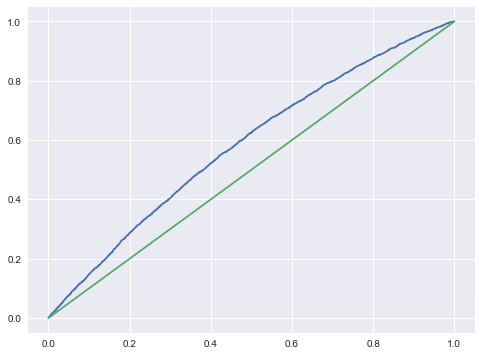

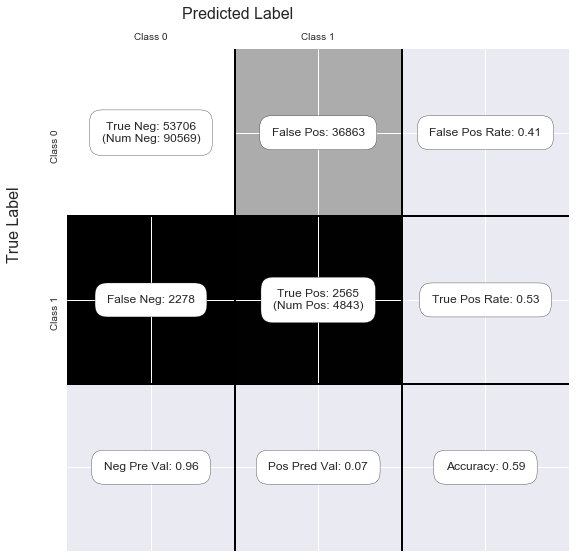

             precision    recall  f1-score   support

          0       0.96      0.59      0.73     90569
          1       0.07      0.53      0.12      4843

avg / total       0.91      0.59      0.70     95412



,decile,size,resp,resp %,cum. resp,cum. resp %
0,1,9542,698,14.41,698,14.41
1,2,9542,662,13.67,1360,28.08
2,3,9540,571,11.79,1931,39.87
3,4,9549,560,11.56,2491,51.44
4,5,9533,513,10.59,3004,62.03
5,6,9541,436,9.00,3440,71.03
6,7,9541,414,8.55,3854,79.58
7,8,9542,377,7.78,4231,87.36
8,9,9540,340,7.02,4571,94.38
9,10,9542,272,5.62,4843,100.00


In [26]:
# check the performance on the testing set
predicted_v = estimator.predict(X_test_new)
probs_v = estimator.predict_proba(X_test_new)

print('Testing Set Accuracy',metrics.accuracy_score(y_test, predicted_v))
print('Testing Set Area Under the ROC',metrics.roc_auc_score(y_test, probs_v[:, 1]))

fpr, tpr, thresholds = metrics.roc_curve(y_test, probs_v[:, 1], pos_label=1)
plt.plot(fpr, tpr, label='Test')
plt.plot([0, 1], [0, 1], '-')
plt.show()

show_confusion_matrix(metrics.confusion_matrix(y_test, predicted_v), ['Class 0', 'Class 1'])

print(metrics.classification_report(y_test, predicted_v))

top_centiles_pref(y_test, probs_v[:, 1])